# Import dataset

In [5]:
# Reading in Multi-file netCDF impossible as file format is not accepted

import os
import pandas as pd
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

full_dataset = dict(time=[], cereal=[], nc=[])
path = 'data'
with os.scandir(path) as dir_data:
    for sub_dir_data in dir_data:
        for f in os.scandir(os.path.join(path, sub_dir_data.name)):
            path_f = os.path.join(path, sub_dir_data.name, f.name)
            time = int(f.name.split('_')[1][:4])
            full_dataset['time'].append(time)
            full_dataset['cereal'].append(sub_dir_data.name)
            full_dataset['nc'].append(nc.Dataset(path_f, 'r'))


df = pd.DataFrame(full_dataset)

In [6]:
# Dataset preprocessing

# Sort data as they are messy when load with scandir
df = df.sort_values(['cereal', 'time'], ignore_index=True) # sorting by time

# Add a 'var' column for display purpose
# Remask with -1 to avoid flatten amplitude
mask_value = 0
list_var = []
for row in df['nc']:
    row_tmp = row['var'][:]
    row_tmp.set_fill_value(-mask_value)
    mask = row_tmp.mask
    list_var.append(np.ma.masked_array(row_tmp.filled(fill_value=-mask_value), mask))
df['var'] = list_var
df.head()

,time,cereal,nc,var
0,1981,maize,<class 'netCDF4._netCDF4.Dataset'>\nroot group...,"[[--, --, --, --, --, --, --, --, --, --, --, ..."
1,1982,maize,<class 'netCDF4._netCDF4.Dataset'>\nroot group...,"[[--, --, --, --, --, --, --, --, --, --, --, ..."
2,1983,maize,<class 'netCDF4._netCDF4.Dataset'>\nroot group...,"[[--, --, --, --, --, --, --, --, --, --, --, ..."
3,1984,maize,<class 'netCDF4._netCDF4.Dataset'>\nroot group...,"[[--, --, --, --, --, --, --, --, --, --, --, ..."
4,1985,maize,<class 'netCDF4._netCDF4.Dataset'>\nroot group...,"[[--, --, --, --, --, --, --, --, --, --, --, ..."


# Check data

The dataset spans from years 1981 to 2016

--------------------

The various types of cereals: 
['maize' 'maize_major' 'maize_second' 'rice' 'rice_major' 'rice_second'
 'soybean' 'wheat' 'wheat_spring' 'wheat_winter']

--------------------


Variable informations:

{'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    units: degrees_east
    long_name: Longitude
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    units: degrees_north
    long_name: Latitude
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'var': <class 'netCDF4._netCDF4.Variable'>
float32 var(lat, lon)
    _FillValue: -999000000.0
unlimited dimensions: 
current shape = (360, 720)
filling on}

--------------------


Dimension informations:

{'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 720, 'lat': <class 'netCDF4

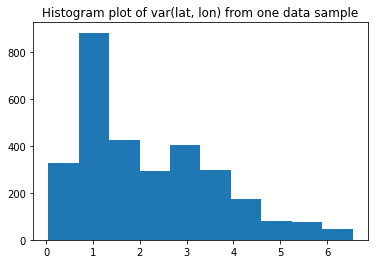

In [7]:
# Checking no data is missing
df.isna().any()

# We keep in mind that data are missing in year 1981 and 2016.
# However, it is not specified where in the data. 
# So we assume that the aforementioned years are just innacurate.

# Year span
print(f"The dataset spans from years {df['time'].min()} to {df['time'].max()}")
print('\n--------------------\n')

# Different types of cereals
print(f"The various types of cereals: \n{df['cereal'].unique()}")
print('\n--------------------\n')


# Variables inside nc4 files
print('\nVariable informations:\n')
print(df['nc'][0].variables)
print('\n--------------------\n')


# fill value = -999000000.0 for var(lat, lon)

# Dimensions inside nc4 files
print('\nDimension informations:\n')
print(df['nc'][0].dimensions)
print('\n--------------------\n')


# Basic stats on var(lat, lon) 
print("Basic stats on var(lat, lon) for one data sample")
var_example = df['nc'][100]['var'][:]

# Get min/max
print(f'\nmin value: {var_example.compressed().min()} (without invalid data)\n')
print(f'max value: {var_example.compressed().max()}\n')


# Get percent of valid values
percent_valid = 100 * var_example.count() / np.prod(var_example.data.shape)
print(f'Percent of valid values: {percent_valid}')
print('\n--------------------\n')


# Histogram plot of var(lat, lon) from a data sample
plt.hist(var_example.compressed());
plt.title('Histogram plot of var(lat, lon) from one data sample')
plt.xlabel = 'Value  bins'
plt.ylabel = 'count'

# Plot var(lat,lon) matrix

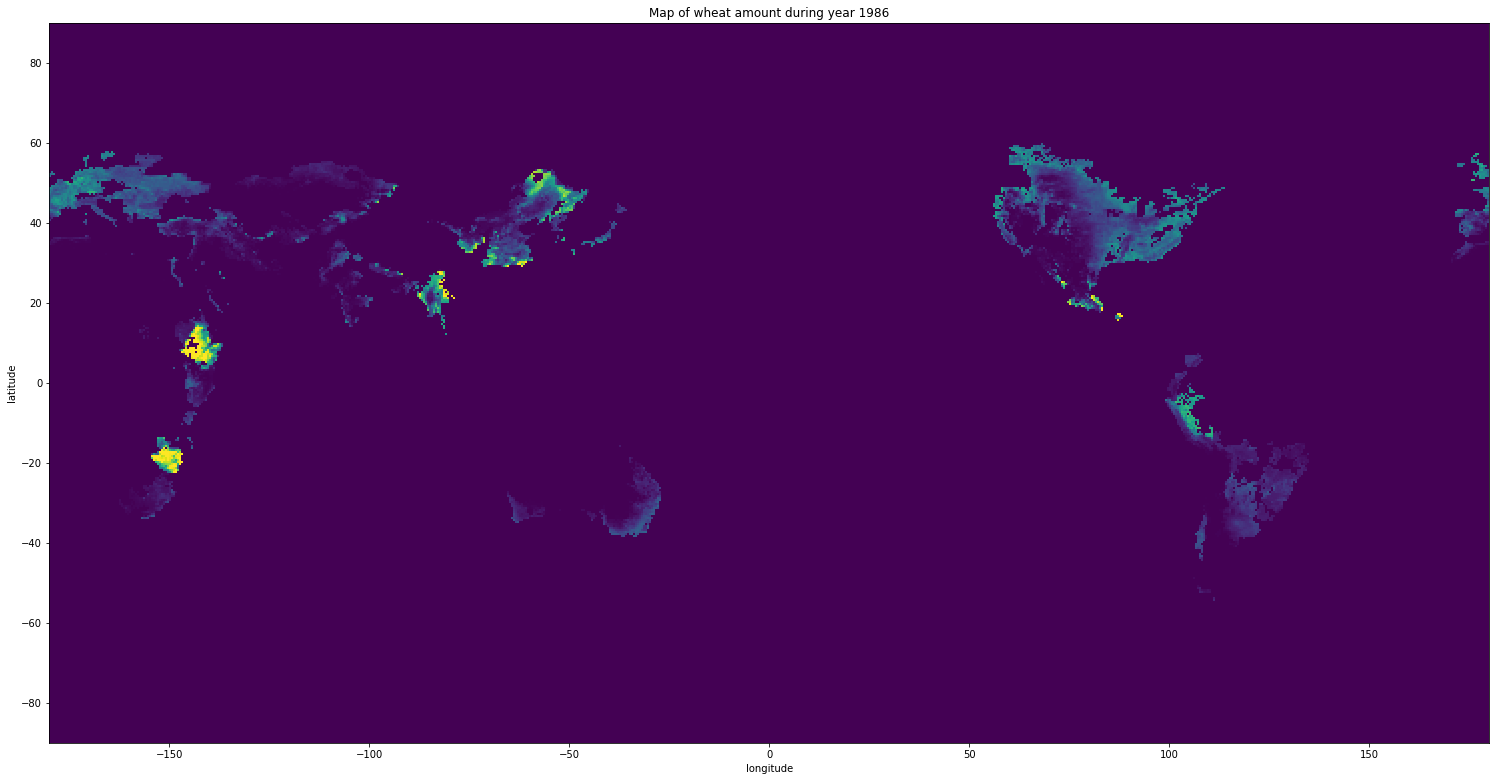

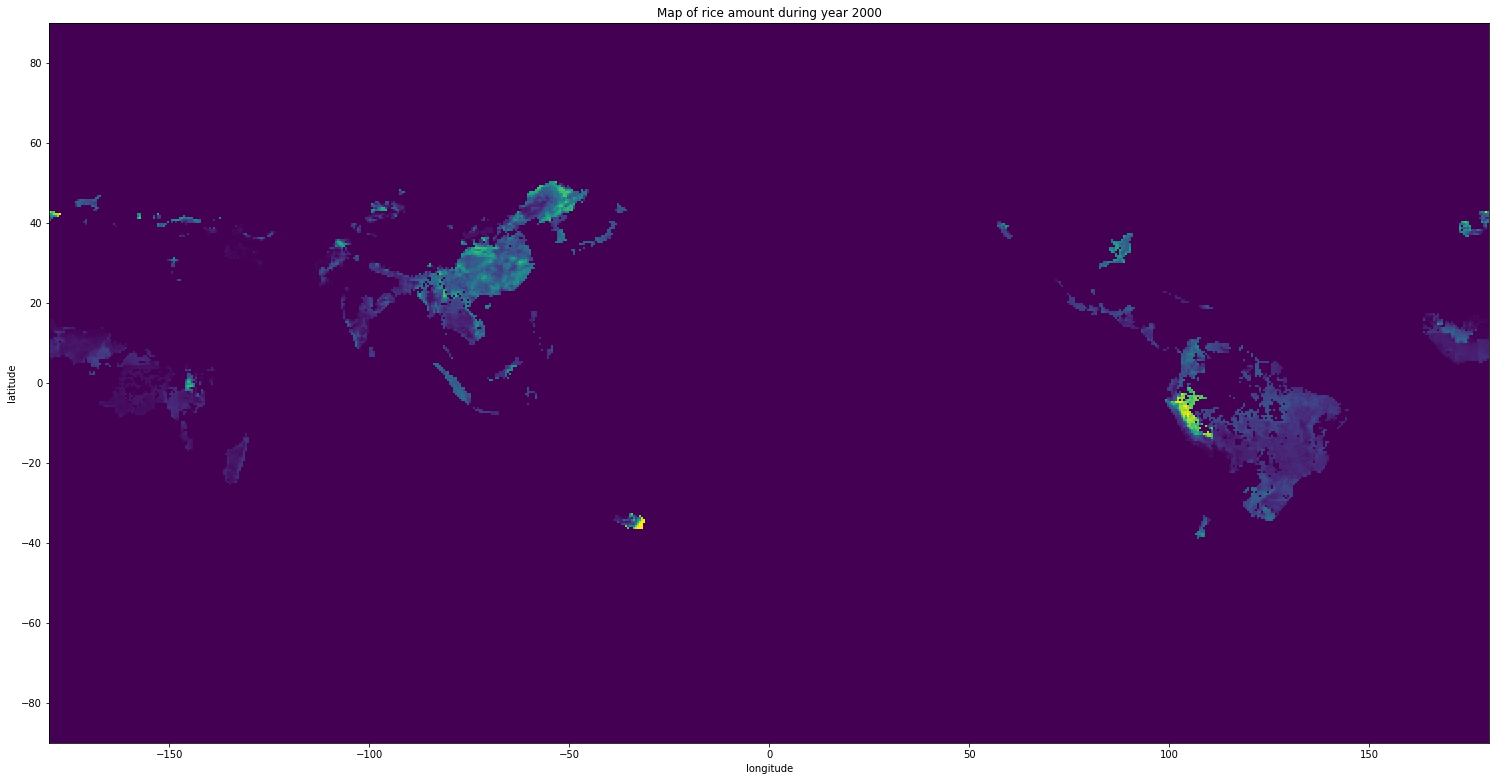

In [8]:
def plot_var(df, cereal=[], time=[]):
    if (cereal and time):
        var = df[(df['cereal'] == cereal) & (df['time'] == time)]['var'].iat[0].data[::-1, :]
    else:
        var = df[::-1, :]
        cereal = ''
        time = ''
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title(f'Map of {cereal} amount during year {time}')
    ax.imshow(var, extent=[-180, 180, -90, 90])
    
    
plot_var(df, cereal='wheat', time=1986)
plot_var(df, cereal='rice', time=2000)

# Some possible analysis

## Global

### Evolution of mean var(lat,lon) averaged across all the cereal along time axis

In general, the crops amount never ceases to increase


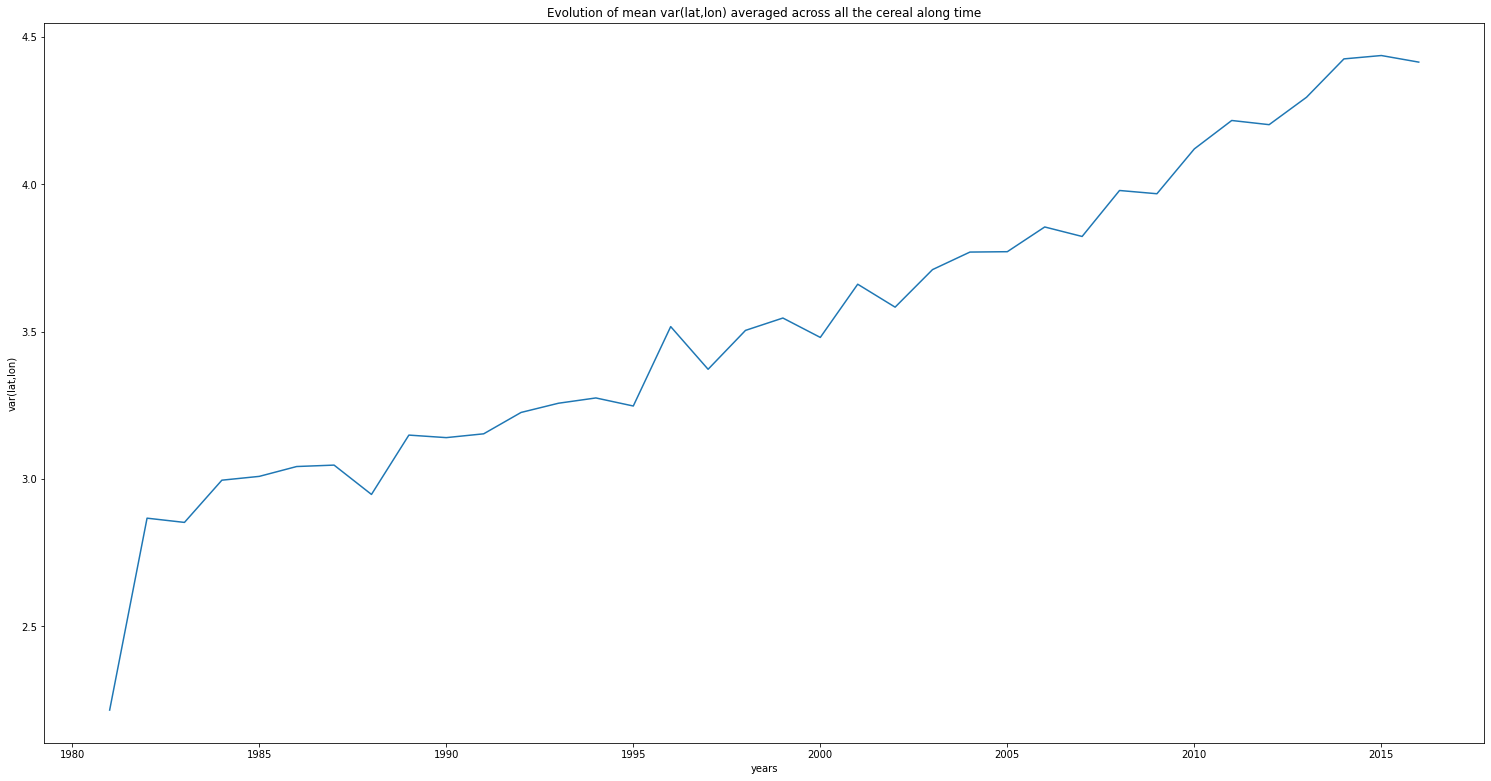

In [9]:
df_by_time = df.groupby(['time'])
cereal_trend = df_by_time.apply(
    lambda grp: np.mean( [row.mean() for row in grp['var']] )
)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.plot(cereal_trend)
ax.set_xlabel('years')
ax.set_ylabel('var(lat,lon)')
ax.set_title('Evolution of mean var(lat,lon) averaged across all the cereal along time')

print('In general, the crops amount never ceases to increase')

### Evolution of mean var(lat,lon) averaged across all years for each cereal type

The rice produces the most while maize during secondary season produces the less.


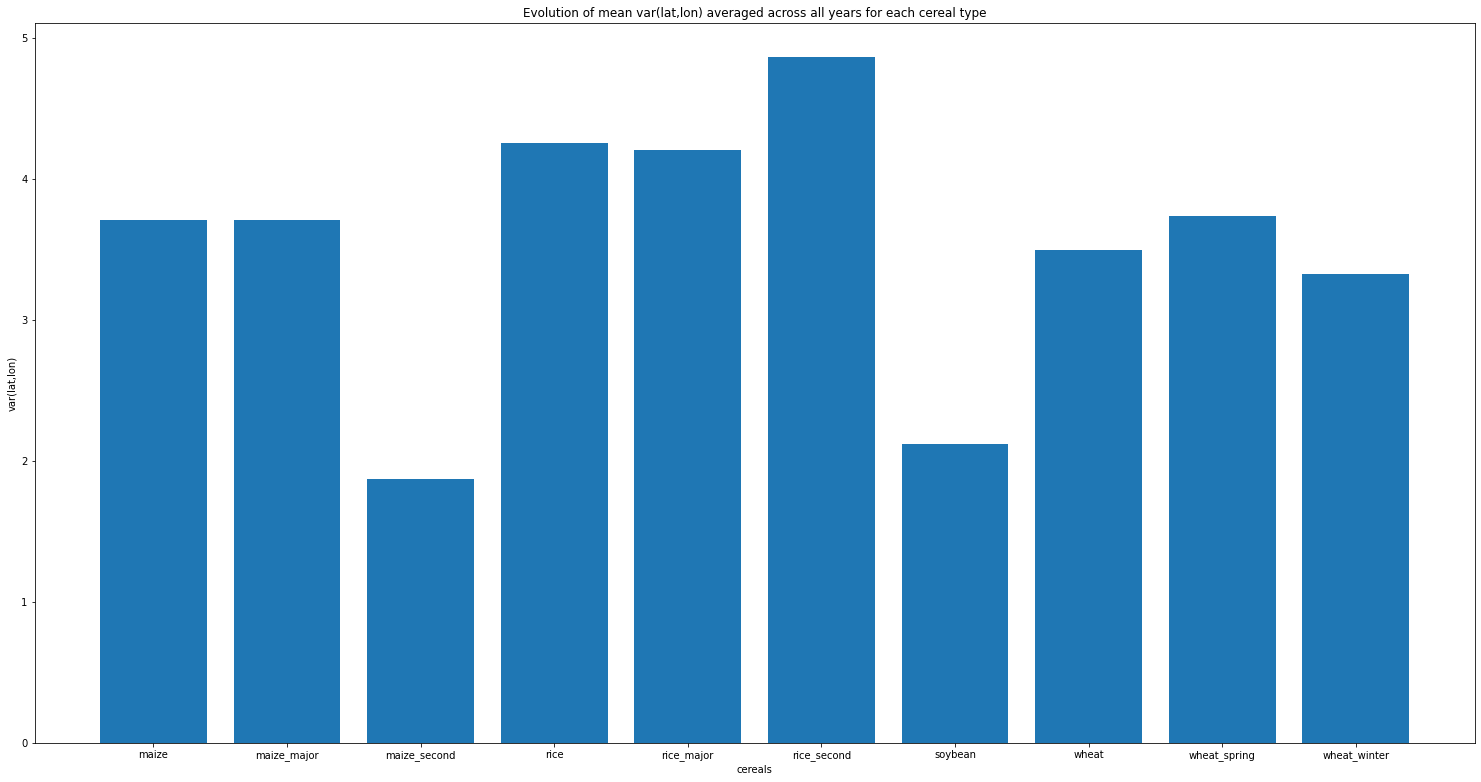

In [10]:
df_by_cereal = df.groupby(['cereal'])
cereal_type = df_by_cereal.apply(
    lambda grp: np.mean( [row.mean() for row in grp['var']] )
)

cereal_label = []
cereal_value = []
for type_c, value_c in cereal_type.items():
    cereal_label.append(type_c)
    cereal_value.append(value_c)

#cereal_type.plot.bar() # Faster but take time to get to know how to modify plot

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
plt.bar(cereal_label, cereal_value);
ax.set_xlabel('cereals')
ax.set_ylabel('var(lat,lon)')
ax.set_title('Evolution of mean var(lat,lon) averaged across all years for each cereal type')

print('The rice produces the most while maize during secondary season produces the less.')

### Evolution of mean var(lat,lon) for each cereal type along time axis


The general trend is still visible but we can see some interesting informations.
For example, the drop at year 2016 for maize in secondary season.



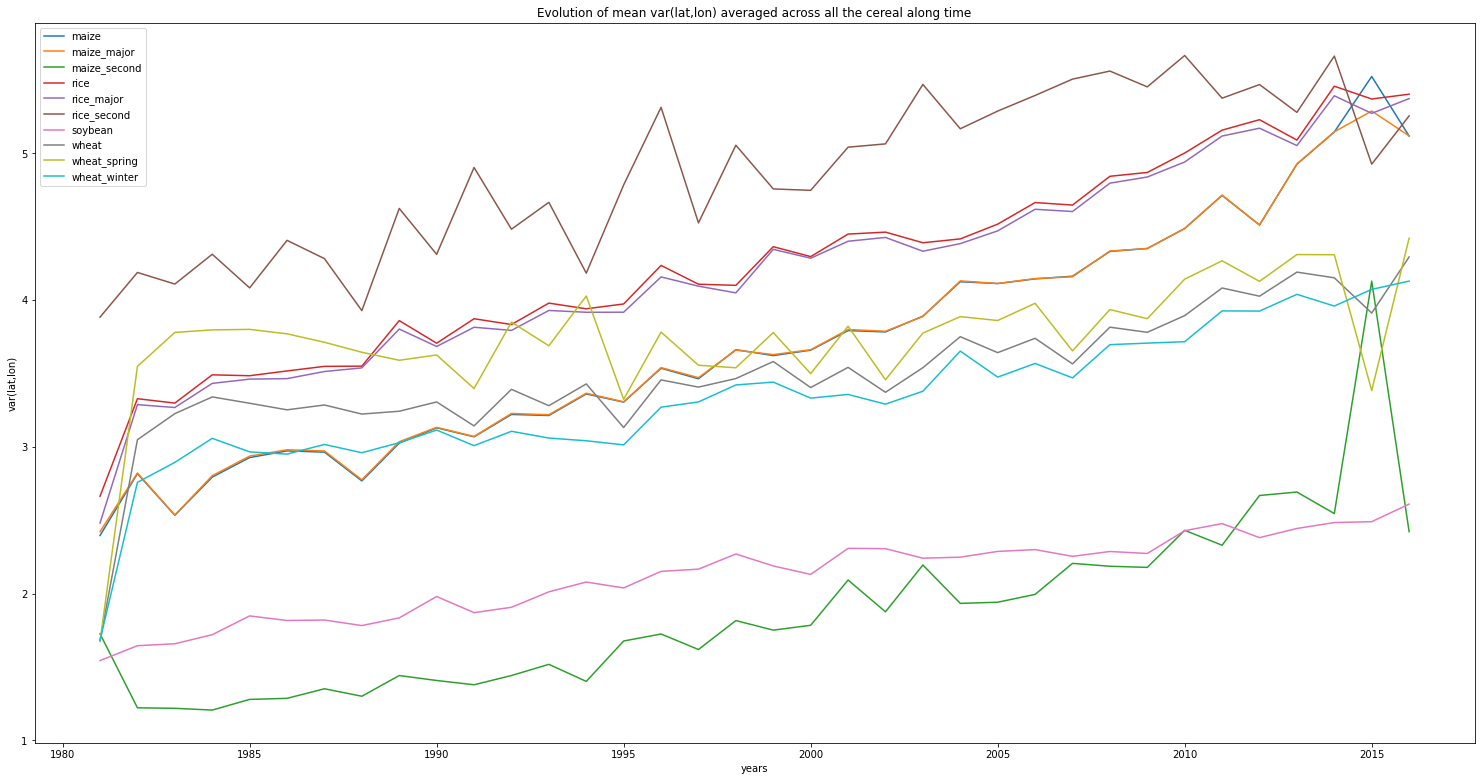

In [11]:
df_by_cereal = df.groupby(['cereal'])
cereal_type_trend = df_by_cereal.apply(
    lambda grp: [row.mean() for row in grp['var']]
)


fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
legend = []
time = df['time'].unique()
for cereal_name, cereal_list in cereal_type_trend.items():
    plt.plot(time, cereal_list)
    legend.append(cereal_name)
ax.legend(legend)
ax.set_xlabel('years')
ax.set_ylabel('var(lat,lon)')
ax.set_title('Evolution of mean var(lat,lon) averaged across all the cereal along time')

comment = '''
The general trend is still visible but we can see some interesting informations.
For example, the drop at year 2016 for maize in secondary season.
'''
print(comment)

### Map of average over all the cereals and all the years

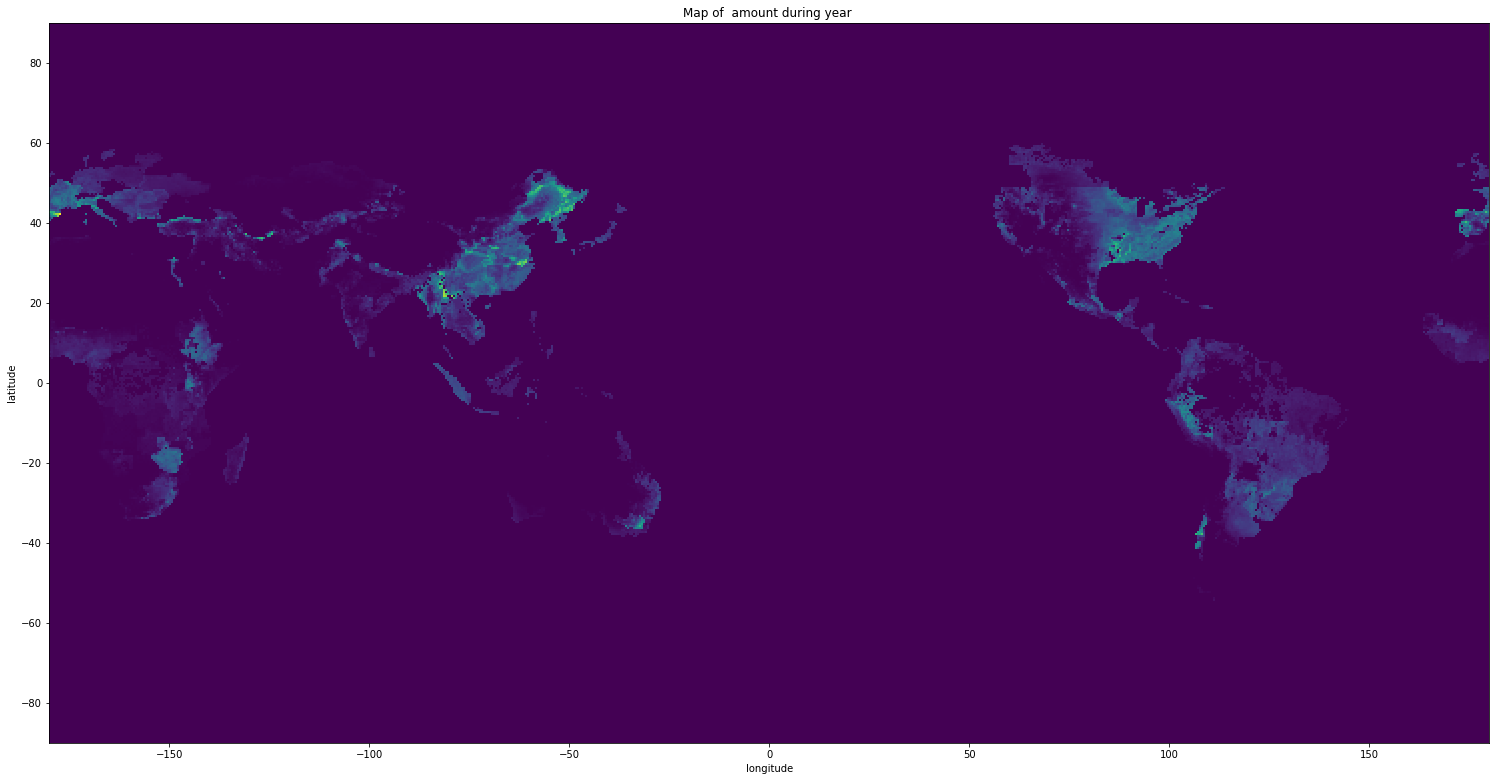

In [12]:
plot_var(df['var'].apply(lambda var: var.data).mean())

In [109]:
a = np.array([row for row in cereal_type_trend])
a.shape

df['var_mean'] = df['var'].apply(lambda row: row.data.mean())
df_by_cereal = df.groupby(['cereal'])
series = np.array(df_by_cereal.get_group('maize')['var_mean'])
series

array([0.04832143, 0.1633876 , 0.1469584 , 0.16196333, 0.16974959,
       0.17247204, 0.17238812, 0.16110867, 0.17592104, 0.1820498 ,
       0.17860036, 0.18749924, 0.18383798, 0.19550264, 0.19228058,
       0.20564899, 0.20151287, 0.2133254 , 0.21075194, 0.21284913,
       0.22060454, 0.22007428, 0.22633988, 0.24012783, 0.2394025 ,
       0.24115114, 0.24229001, 0.25197288, 0.25314978, 0.26121351,
       0.23125251, 0.22134745, 0.24170433, 0.25244036, 0.23728937,
       0.25107959])

# Prediction

## ARIMA Model

predicted=0.243886, expected=0.251080
Test RMSE: 0.007


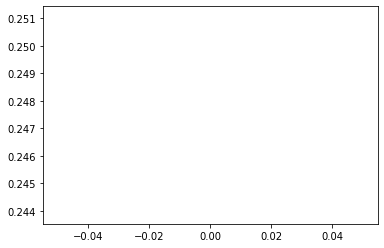

In [116]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings


train = series[:-1]
test = series[-1:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [111]:
# evaluate an ARIMA model for a given order (p,d,q)

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.5f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [112]:
# Grid search of ARIMA model to get best parameters

p_values = [1, 2, 3, 4]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series, p_values, d_values, q_values)

ARIMA(1, 0, 0) MSE=0.00026
ARIMA(1, 0, 1) MSE=0.00024
ARIMA(1, 0, 2) MSE=0.00096
ARIMA(1, 1, 0) MSE=0.00034
ARIMA(1, 1, 1) MSE=0.00031
ARIMA(1, 1, 2) MSE=0.00094
ARIMA(1, 2, 0) MSE=0.00063
ARIMA(1, 2, 1) MSE=0.00045
ARIMA(1, 2, 2) MSE=0.00063
ARIMA(2, 0, 0) MSE=0.00035
ARIMA(2, 0, 1) MSE=0.00036
ARIMA(2, 0, 2) MSE=0.00107
ARIMA(2, 1, 0) MSE=0.00042
ARIMA(2, 1, 1) MSE=0.00040
ARIMA(2, 1, 2) MSE=0.00090
ARIMA(2, 2, 0) MSE=0.00076
ARIMA(2, 2, 1) MSE=0.00054
ARIMA(2, 2, 2) MSE=0.00087
ARIMA(3, 0, 0) MSE=0.00041
ARIMA(3, 0, 1) MSE=0.00059
ARIMA(3, 0, 2) MSE=0.00071
ARIMA(3, 1, 0) MSE=0.00069
ARIMA(3, 1, 1) MSE=0.00070
ARIMA(3, 1, 2) MSE=0.00092
ARIMA(3, 2, 0) MSE=0.00074
ARIMA(3, 2, 1) MSE=0.00061
ARIMA(3, 2, 2) MSE=0.00092
ARIMA(4, 0, 0) MSE=0.00065
ARIMA(4, 0, 1) MSE=0.00071
ARIMA(4, 0, 2) MSE=0.00094
ARIMA(4, 1, 0) MSE=0.00077
ARIMA(4, 1, 1) MSE=0.00065
ARIMA(4, 1, 2) MSE=0.00092
ARIMA(4, 2, 0) MSE=0.00064
ARIMA(4, 2, 1) MSE=0.00084
ARIMA(4, 2, 2) MSE=0.00078
Best ARIMA(1, 0, 1) MSE=0.00

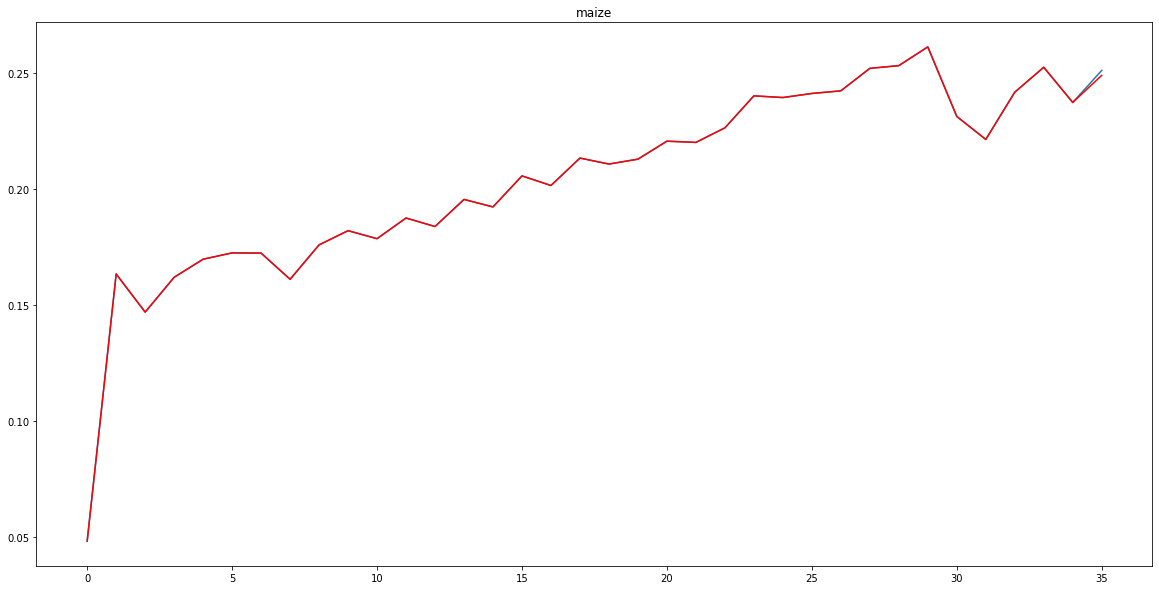

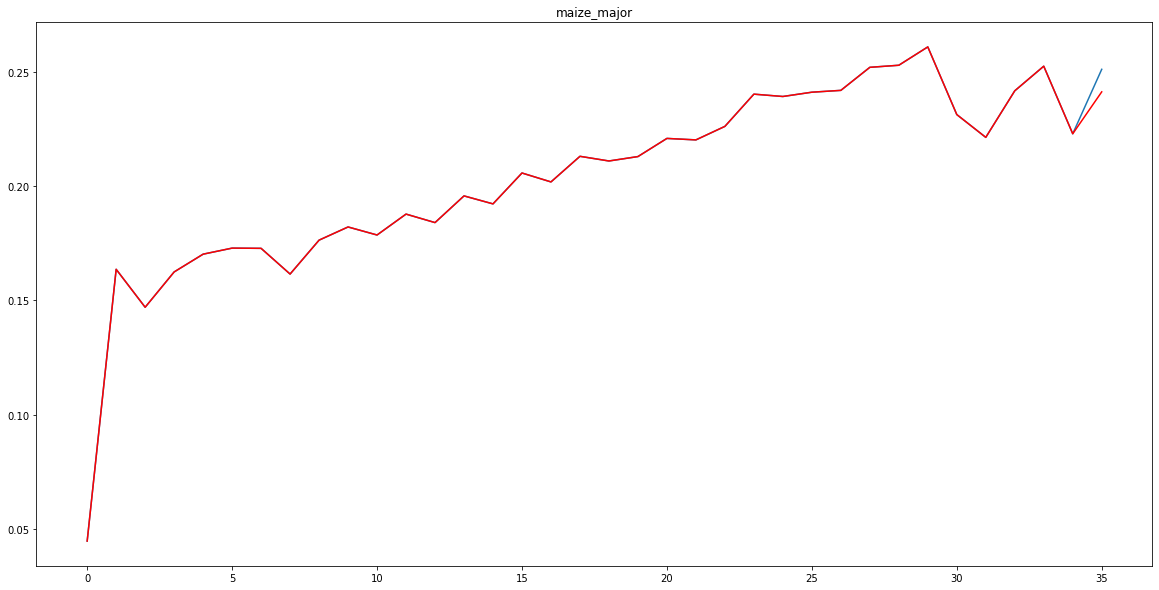

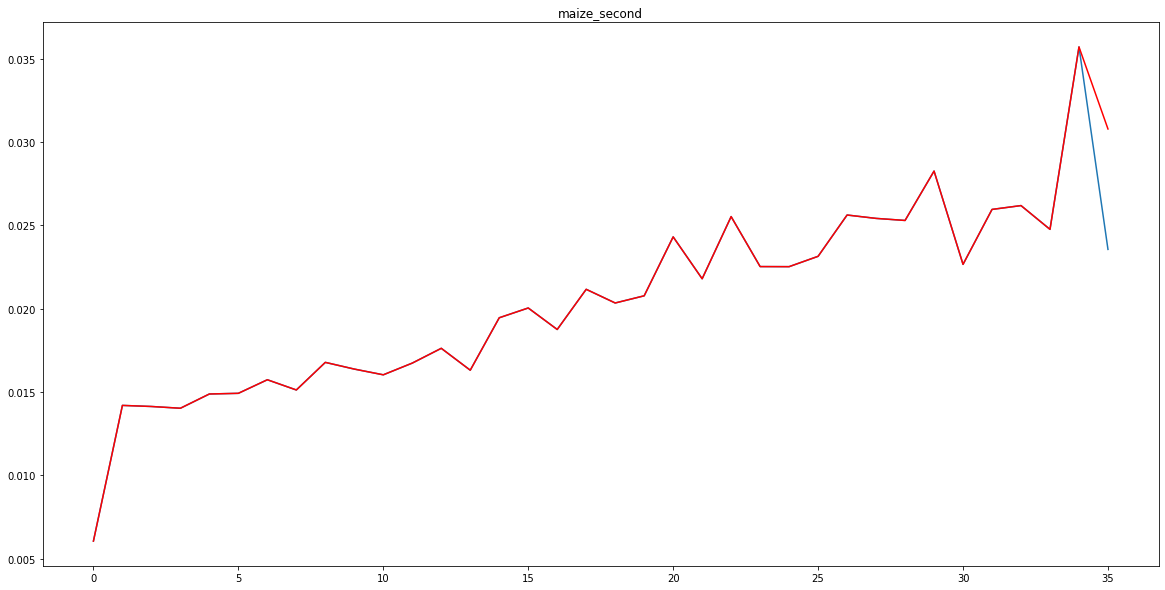

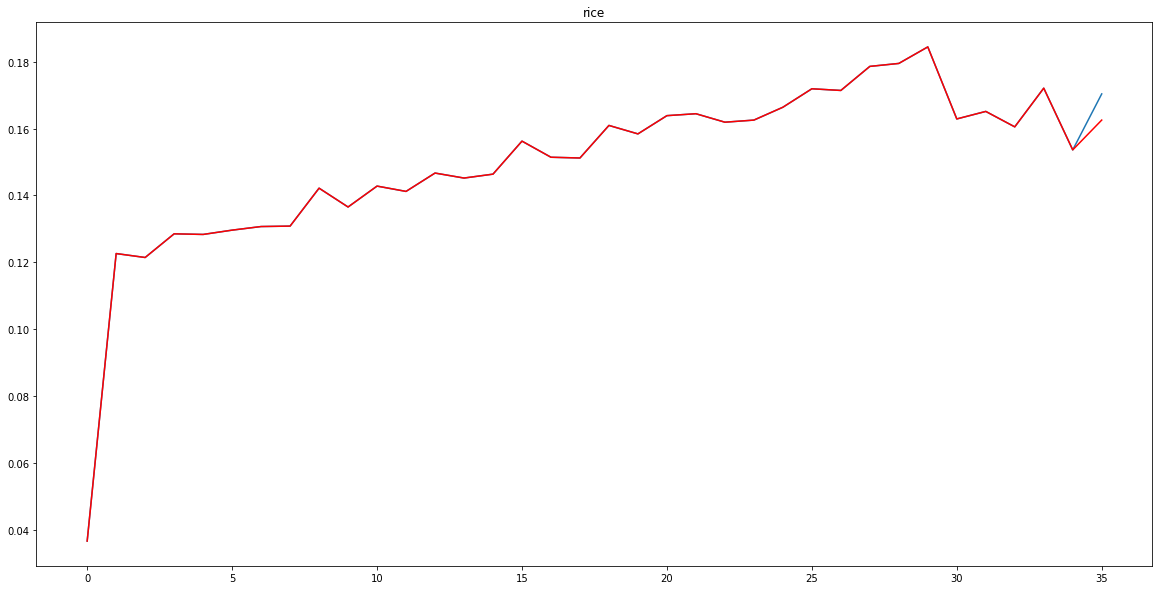

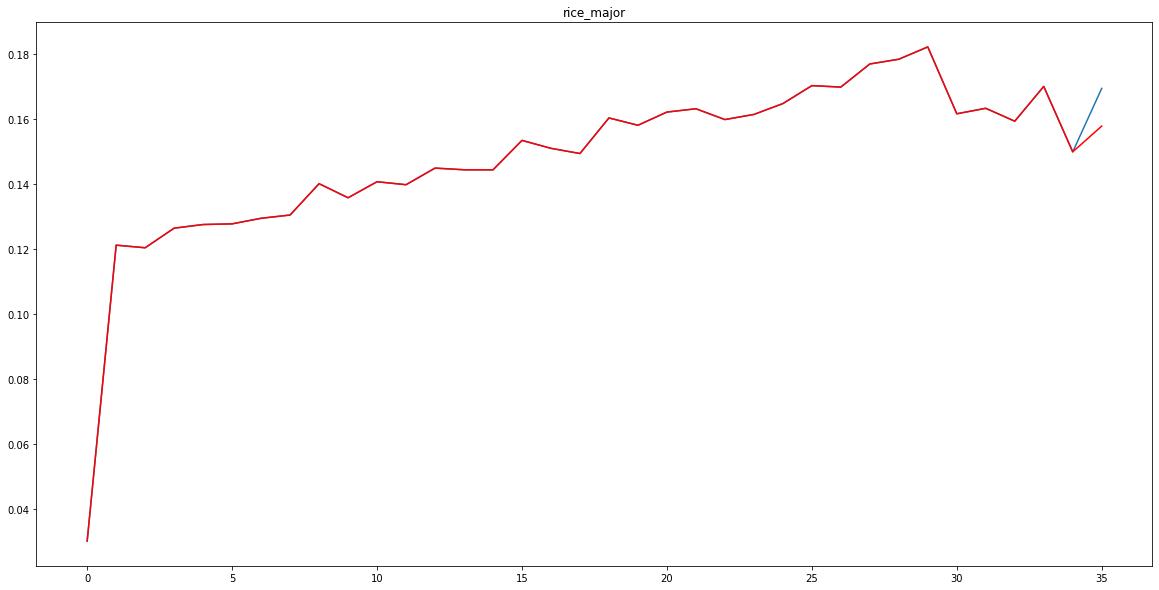

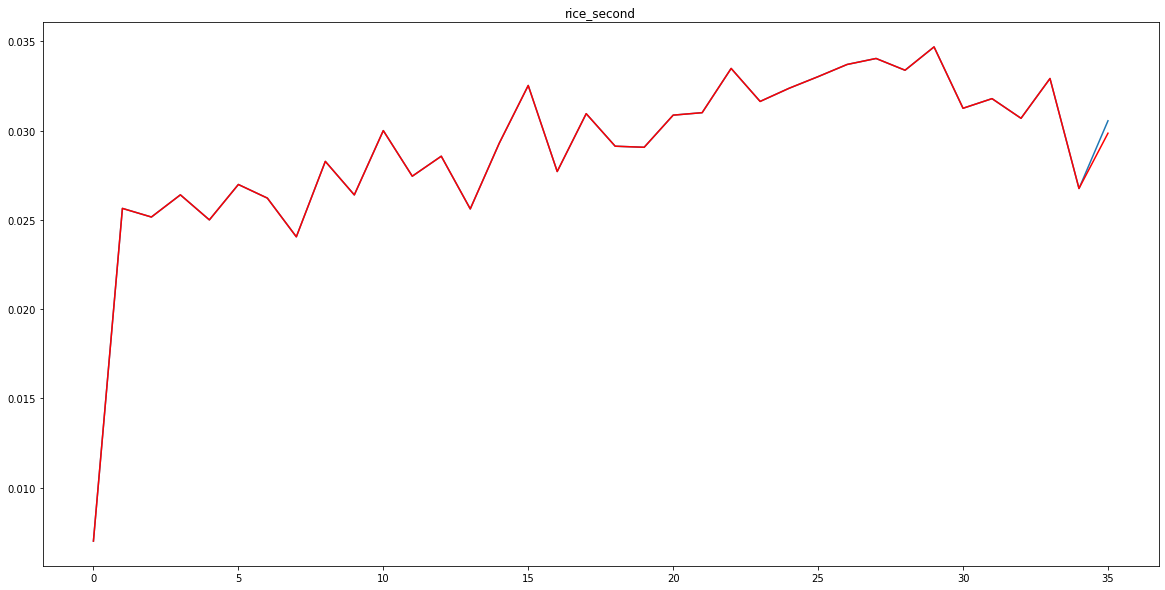

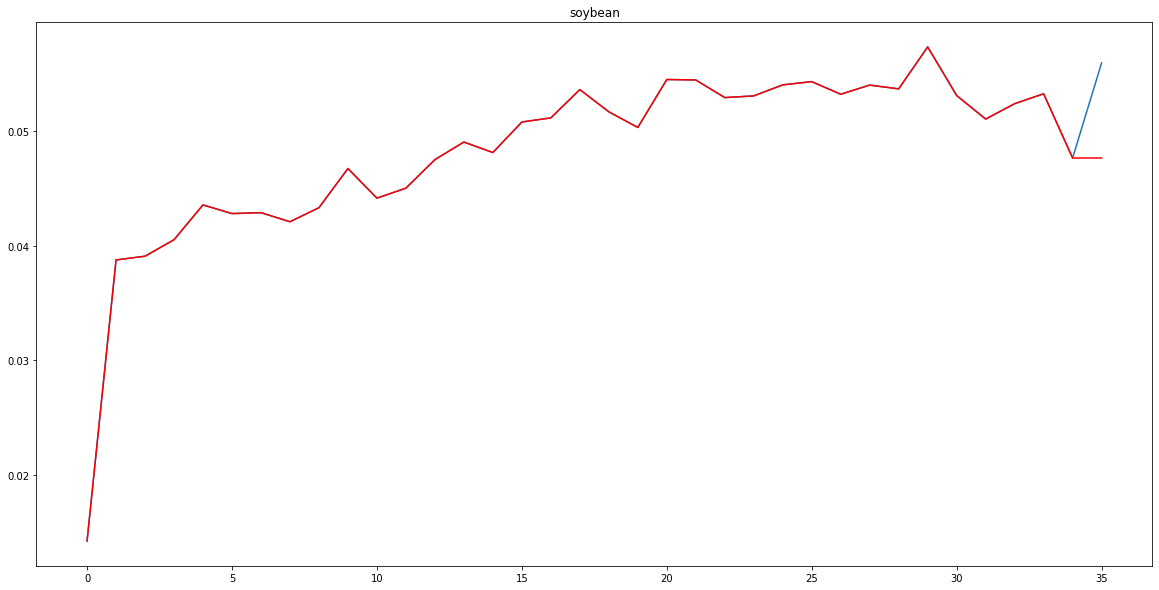

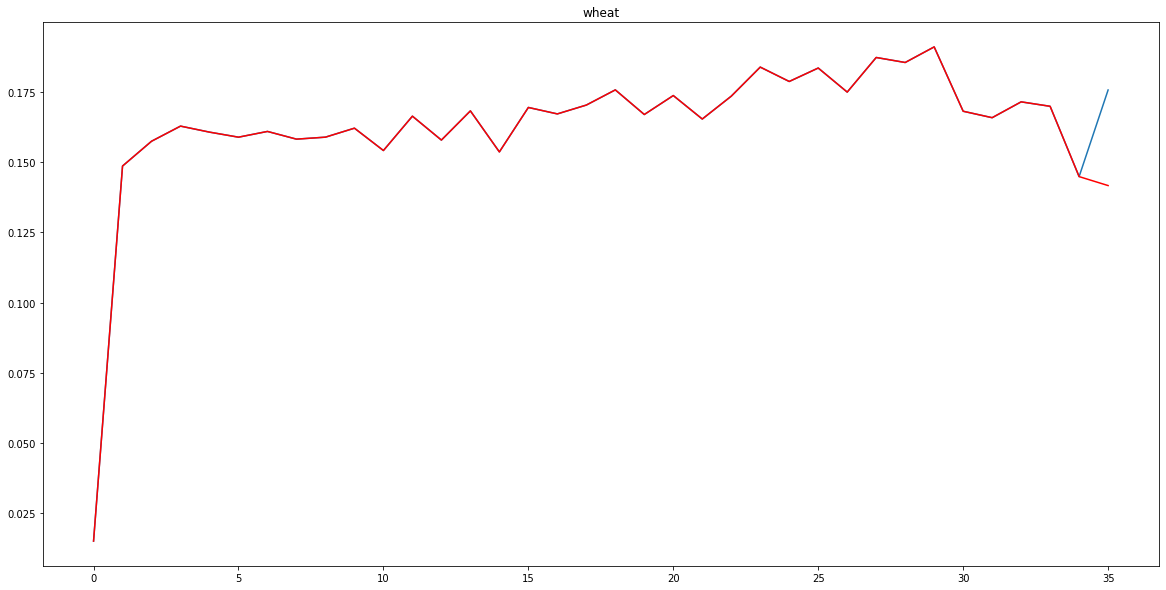

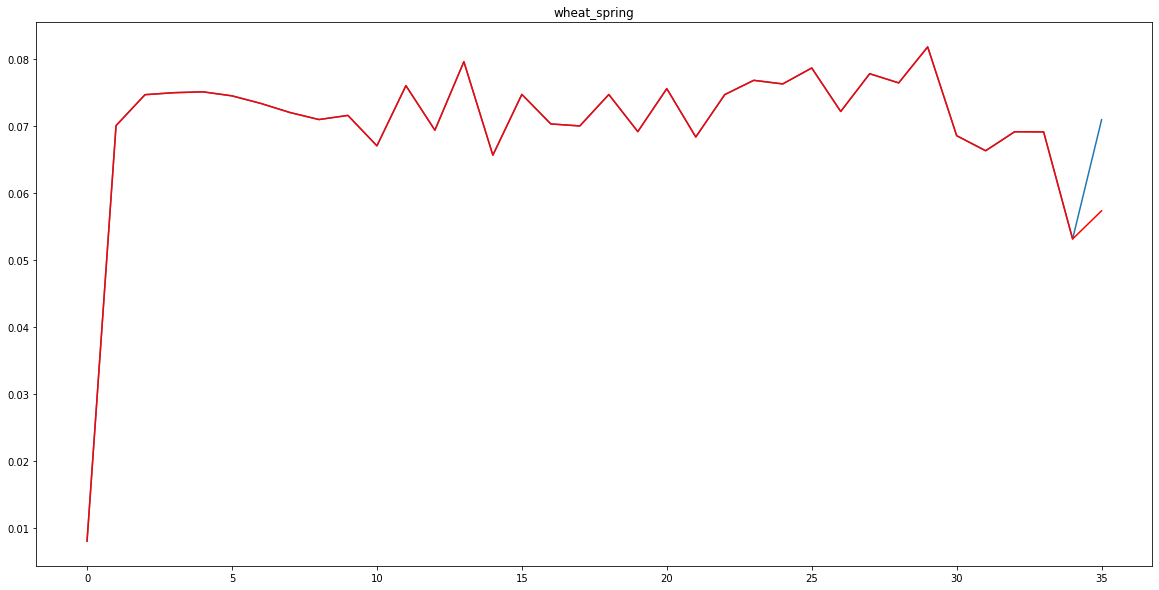

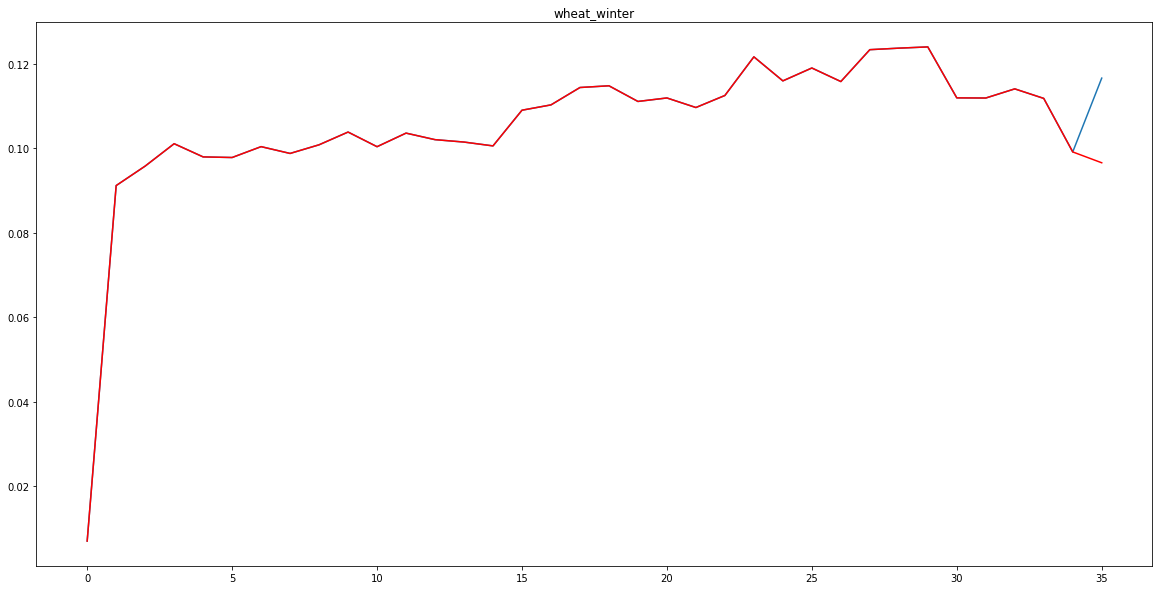

In [153]:
# Predict last year based on all previous years

for c in df['cereal'].unique():
    series = np.array(df_by_cereal.get_group(c)['var_mean'])

    model = ARIMA(series[:-1], order=(2,1,1))
    predicted_value = model.fit().forecast()
    series_predicted = series.copy()
    series_predicted[-1] = predicted_value
    fig = plt.figure(figsize=(20,10))
    plt.title(c)
    plt.plot(series)
    plt.plot(series_predicted, 'r')

